In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import collections
import datetime
from tqdm import tqdm_notebook as tqdm
%matplotlib inline 
sns.set(color_codes=True)
from numpy import median


In [176]:
data = pd.read_csv("game_results.csv",index_col="id").to_dict("records")
res = pd.read_csv("predictions.csv",index_col="id") 

In [177]:
users_first_time = collections.defaultdict(lambda :  datetime.datetime.now())
for d in tqdm(data):
    users_first_time[d['user_id']] = min(users_first_time[d['user_id']] ,datetime.datetime.strptime(d["timestamp"],'%Y-%m-%d %H:%M:%S'))

In [178]:
# We will cut the data to a distance of 1 day from the moment of registration

games_by_user = collections.defaultdict(list)
for d in tqdm(data):
    if (datetime.datetime.strptime(d["timestamp"],'%Y-%m-%d %H:%M:%S') - users_first_time[d['user_id']]).days > 0:
        continue
#         pass
    games_by_user[d['user_id']].append(d)

In [179]:
users = []
for uid in tqdm(games_by_user):
    user = {}
    user["id"] = uid
    
    games = games_by_user[uid]
    gamescount = len(games)
    
    # The number of days between the first and last game
    timestamps = [datetime.datetime.strptime(g["timestamp"],'%Y-%m-%d %H:%M:%S') 
                  for g in games]
    
    user["reg_day_type"] = timestamps[0].weekday()
    user["last_game_win"] = 0
    visits = 1
    for t in range(len(timestamps)-1):
        if (timestamps[t+1] - timestamps[t]).seconds > 3600:
            visits += 1
            user["last_game_win"] += games[t]["winner"]

    user["gamescount"] = gamescount
    user["visits"] = visits
        
    user["total_win"] = sum([g["winner"] for g in games])
    user["total_lost"] = gamescount - user["total_win"]
    
    user["total_length"] = sum([g["length"] for g in games])
    user["total_magic_used"] = sum([g["winner"] for g in games])
    user["total_cards_done"] = sum([g["player_cards"] for g in games])
        
    types = collections.Counter([g["type"] for g in games])
    
    turnir_counts = sum([g["type"] == 2 for g in games])
    user["turnir_counts"] = turnir_counts
    user["turnir_wins"] = sum([g["type"] == 2 and g['round'] ==3 and g["winner"] == 1 for g in games])
    
        
    for k in types:
        user[f"type_{k}"] = types[k] / gamescount
    
    rounds = collections.defaultdict(int)
    for g in games:
        if g['type'] == 2:
            rounds[g['round']] +=1
            
    for k in rounds:
        user[f"round_type_{k}"] = rounds[k] / turnir_counts
    
    users.append(user)

data = pd.DataFrame.from_records(users).set_index("id").fillna(0)   
data.head()

,gamescount,last_game_win,reg_day_type,round_type_1,round_type_2,round_type_3,total_cards_done,total_length,total_lost,total_magic_used,total_win,turnir_counts,turnir_wins,type_1,type_2,type_3,type_4,visits
id,,,,,,,,,,,,,,,,,,
218490,39,0,6,0.0,0.0,0.0,1008,21572,8,31,31,0,0,1.0,0.0,0.0,0.0,3
218492,3,0,6,0.0,0.0,0.0,108,949,0,3,3,0,0,1.0,0.0,0.0,0.0,1
218493,7,0,6,0.0,0.0,0.0,290,3298,3,4,4,0,0,1.0,0.0,0.0,0.0,1
218499,3,0,6,0.0,0.0,0.0,73,347,0,3,3,0,0,1.0,0.0,0.0,0.0,1
218507,4,0,6,0.0,0.0,0.0,156,724,1,3,3,0,0,1.0,0.0,0.0,0.0,1


In [180]:
data["skill"] = data["total_win"] / data["gamescount"]
data["time_for_card"] = data["total_length"] / (data["total_cards_done"]+1)
data["magic_for_card"] = data["total_magic_used"] / (data["total_cards_done"]+1)

data["time_for_game"] = data["total_length"] / data["gamescount"]
data["card_for_game"] = data["total_cards_done"] / data["gamescount"]
data["magic_for_game"] = data["total_magic_used"] / data["gamescount"]
data["games_for_visit"] = data["gamescount"] / data["visits"]

### Выделенные характеристики

* `gamescount` - число сыгранных партий
* `last_game_win` - результат последней игры
* `reg_day_type` - день регистрации (ПН, ВТ ..)
* `round_type_1` - число игр на 1 этапе чемпионата
* `round_type_2` - число игр на 2 этапе чемпионата
* `round_type_3`- число игр на 3 этапе чемпионата
* `total_cards_done` - число сыгранных карт
* `total_length` - общая время в игре
* `total_lost` - общее число сброшенных карт
* `total_magic_used` - общее число потраченной магии
* `total_win` - общее число побед
* `turnir_counts` - число сыгранных турниров
* `turnir_wins` - число побед в турнирах
* `visits` - число заходов в игру
* `type_1` - число игр type 1
* `type_2` - число игр type 2
* `type_3` - число игр type 3
* `type_4` - число игр type 4

* `magic_for_card` - среднее число магии потраченной на 1 карту
* `time_for_card` - среднее время выбора карты
* `skill` - уровень игрока
* `time_for_game` - среднее время на партию
* `card_for_game` - среднее число карт в игре
* `magic_for_game` - среднее число магии на карту
* `games_for_visit` - среднее число сыгранных игр за заход

In [181]:
data_kosmo = pd.concat([data, res], axis=1, sort=False)
data_kosmo = data_kosmo[data_kosmo['prediction'].notna()]
collections.Counter(data_kosmo['prediction'])

Counter({0.0: 2841, 1.0: 1159})

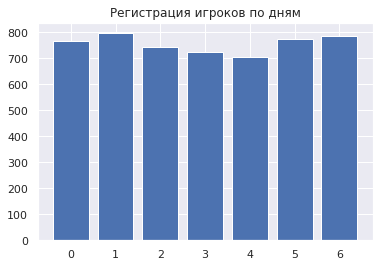

In [182]:
fig, ax = plt.subplots()
ax.set(title='Регистрация игроков по дням')
red_days = collections.Counter(data["reg_day_type"])
ax.bar(red_days.keys(),red_days.values());

Люди регестрируются равномерно, день регистрации не на что не влияет

## EAT

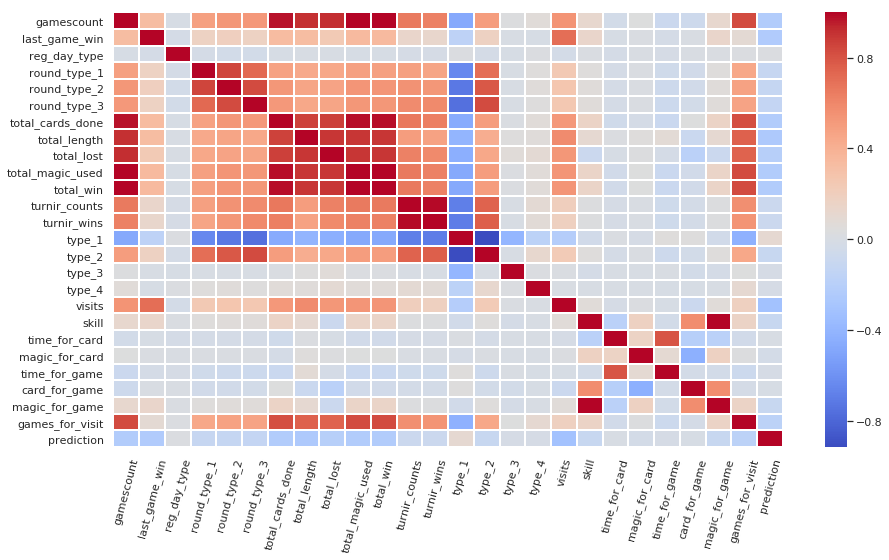

In [183]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 8)

g = sns.heatmap(data_kosmo.corr(),cmap='coolwarm',annot=False,linecolor='white',linewidths=1)
labels = g.get_xticklabels()
g.set_xticklabels(labels,rotation=75);

**Оценим признаки по данным из heatmap**

Больше всего нас интересует последняя строчка: `prediction`, сильнее всего НЕкосмотнавтность пользователя связана с числом дней c момента регистрации до последнего матча (проверенно во время тестов), чуть менее с числом активных дней в игре (проверенно во время тестов) и общим числом сыгранных карт / потраченной маны и времени, а также с рспределением по раундам в чемпионатах. Вопреки ожиданиям, космонавтность плохо коррелирует с количеством побед и уровнем игрока. По правилам игры дают много бонусов за сброс сетов и эти бонусы вляют на место в общей турнирной таблице. Есть вероятность что космонавтность связана со стратегией игрока, направленной на сброс максимально большого числа карт ради набора бонусов, и люди приходят к этому по мере получения опыта в игре. В пользу этой теории также гворит и то, что люди, играющие чаще других первый раунд обладают повышенной космонавтностью

- Судя по кореляции признаков космнавтность это негативное качество, как марсианин в нардах и более правильная тактика игры у тех кто __НЕ космонавт__

- `type_3` и `type4` вообще ни с чем не корелируют и % игр на тренировках с ботом у всех пользоватлей равноспределенно среди пользователей всех типов, а также среднее время на размышления, их можно удалить

245 / 4000


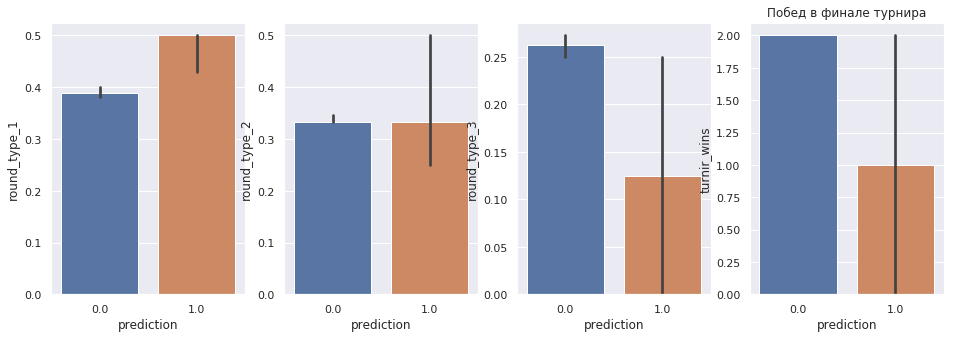

In [184]:
fig = plt.figure()
fig.set_size_inches(16, 5)

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)


tips = data_kosmo[data_kosmo["turnir_counts"] > 0]
sns.barplot(x='prediction', y='round_type_1', data=tips, ax=ax1, estimator=median)
sns.barplot(x='prediction', y='round_type_2', data=tips, ax=ax2, estimator=median)
sns.barplot(x='prediction', y='round_type_3', data=tips, ax=ax3, estimator=median)
sns.barplot(x='prediction', y='turnir_wins', data=tips, ax=ax4, estimator=median);

ax4.set(title="Побед в финале турнира")

print(len(tips),"/",len(data_kosmo))

**Роль среднего этапа соревнования на всеобщем турнире**

Действительно, есть корреляция, причем чем выше игрок всреднем забираеться по турнирной таблице, тем более его стратегия игры "нексомонавтская", причем для финального раунда различие почти в 2 раза. Не космонавты такде почти в 3 раза чаще побеждают во всем турнире

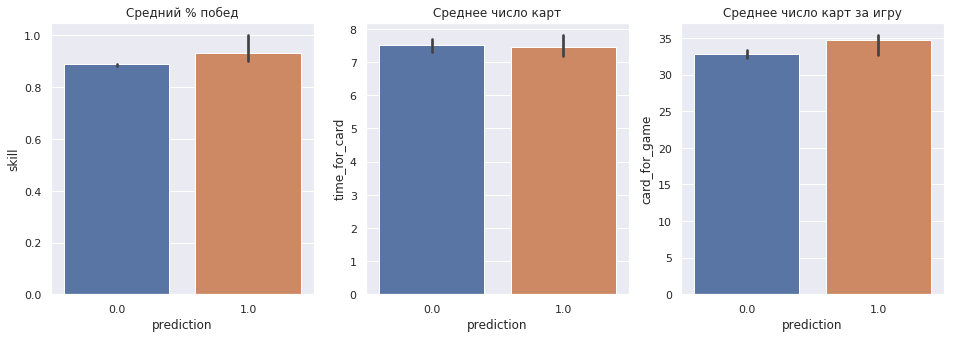

In [185]:
fig = plt.figure()
fig.set_size_inches(16, 5)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


ax1.set(title='Средний % побед')
ax2.set(title='Среднее число карт')
ax3.set(title='Среднее число карт за игру')



sns.barplot(x='prediction', y='skill', data=data_kosmo, ax = ax1, estimator=median)
sns.barplot(x='prediction', y='time_for_card', data=data_kosmo, ax = ax2, estimator=median)
sns.barplot(x='prediction', y='card_for_game', data=data_kosmo, ax = ax3, estimator=median);



**Роль относительных значений по параметрам игрока**

Средние значения ни на что не влияют :( Вероятно слабым игрокам игра дает слабых соперников и все тратят +- одинаковое чило карт

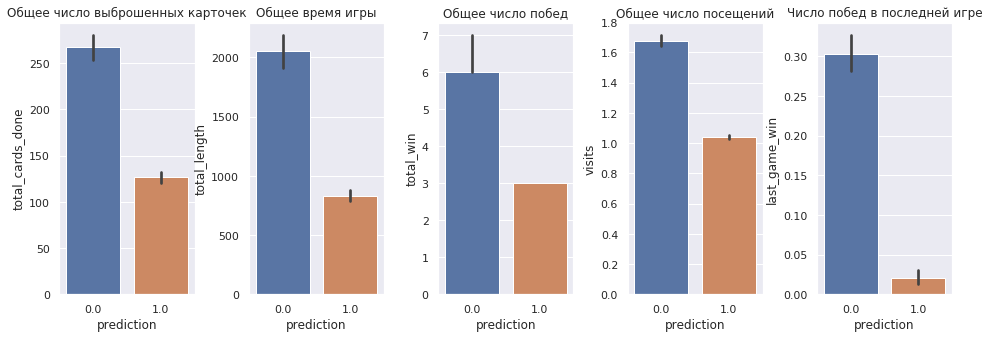

In [186]:
# tips = data_kosmo[data_kosmo["turnir_counts"] == 0]
fig = plt.figure()
fig.set_size_inches(16, 5)
gs = fig.add_gridspec(1, 5,wspace=0.4)


ax1 = fig.add_subplot(gs[0,0])
ax1.set(title="Общее число выброшенных карточек")
ax2 = fig.add_subplot(gs[0,1])
ax2.set(title="Общее время игры")
ax3 = fig.add_subplot(gs[0,2])
ax3.set(title="Общее число побед")
ax4 = fig.add_subplot(gs[0,3])
ax4.set(title="Общее число посещений")
ax5 = fig.add_subplot(gs[0,4])
ax5.set(title="Число побед в последней игре")

sns.barplot(x='prediction', y='total_cards_done', data=data_kosmo, ax=ax1, estimator=median)
sns.barplot(x='prediction', y='total_length', data=data_kosmo, ax=ax2, estimator=median)
sns.barplot(x='prediction', y='total_win', data=data_kosmo, ax=ax3, estimator=median)
sns.barplot(x='prediction', y='visits', data=data_kosmo, ax=ax4);
sns.barplot(x='prediction', y='last_game_win', data=data_kosmo, ax=ax5);




**Посморим на абсолютные значений**

Воу, медианные по абсолютным значениям отличаются на порядок в зависимости от космонавтности, добавим признаки больше / меньше среднемедианных значений по столбцам. Также заметим, что если игрок за сутки заходил в игру более 1 раза (разность времени между матчами была больше часа) то он почти 100% не космонавт. Также интересно, что у космонавтов очень мало побед в последнем матче, практически все проигрывали и выходили, вероятно растроившись и забыв.

In [187]:
data_kosmo["more_win_then_mean"] = data_kosmo["total_win"] > data_kosmo["total_win"].median()
data_kosmo["more_length_then_mean"] = data_kosmo["total_length"] > data_kosmo["total_length"].median()
data_kosmo["more_magic_then_mean"] = data_kosmo["total_magic_used"] > data_kosmo["total_magic_used"].median()

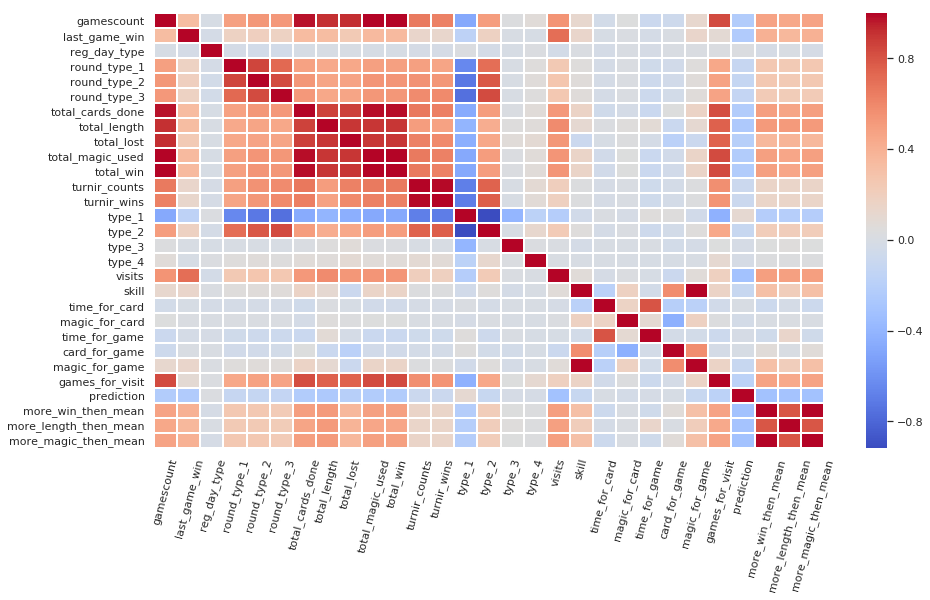

In [188]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(15, 8)

g = sns.heatmap(data_kosmo.corr(),cmap='coolwarm',annot=False,linecolor='white',linewidths=1)
labels = g.get_xticklabels()
g.set_xticklabels(labels,rotation=75);

**Итоговый heatmap выводы**

Сильная кореляция с новыми данными. Космонавтность связана с общим числом игр и соотв времени, проведенно в игре, количеством раундов и так далее. Низкая роль средних показателей вероятно связана с тем, что новичкам игра дает более простые стартовые сеты карт, а также более слабых противников на турнире. Опыт также  коррелирует с навыками игры в чемпионатах и желанием игрока принимать в них участие. Можно сформулировать определение: **космонавт** - новичек в игре, человек который зашел потыкать, сыграл пару раундов и забил, не выработов свою стратегию игры и не достигнув значимого результата. Если эти выводы верны, выделенных ниже признаков будет доствточно, чтобы с высокой точностью предсказывть статус игрока.

## Итоговы data preparing

In [189]:
data["more_win_then_mean"] = data["total_win"] > data["total_win"].median()
data["more_length_then_mean"] = data["total_length"] > data["total_length"].median()
data["more_magic_then_mean"] = data["total_magic_used"] > data["total_magic_used"].median()

del data["type_3"]
del data["type_4"]
del data["time_for_game"]
del data["time_for_card"]
del data["reg_day_type"]

In [190]:
data.to_csv("user_features.csv")

In [191]:
data.head()

,gamescount,last_game_win,round_type_1,round_type_2,round_type_3,total_cards_done,total_length,total_lost,total_magic_used,total_win,...,type_2,visits,skill,magic_for_card,card_for_game,magic_for_game,games_for_visit,more_win_then_mean,more_length_then_mean,more_magic_then_mean
id,,,,,,,,,,,,,,,,,,,,,
218490,39,0,0.0,0.0,0.0,1008,21572,8,31,31,...,0.0,3,0.794872,0.030723,25.846154,0.794872,13.0,True,True,True
218492,3,0,0.0,0.0,0.0,108,949,0,3,3,...,0.0,1,1.000000,0.027523,36.000000,1.000000,3.0,False,False,False
218493,7,0,0.0,0.0,0.0,290,3298,3,4,4,...,0.0,1,0.571429,0.013746,41.428571,0.571429,7.0,False,True,False
218499,3,0,0.0,0.0,0.0,73,347,0,3,3,...,0.0,1,1.000000,0.040541,24.333333,1.000000,3.0,False,False,False
218507,4,0,0.0,0.0,0.0,156,724,1,3,3,...,0.0,1,0.750000,0.019108,39.000000,0.750000,4.0,False,False,False


_P.S. Несколько раз перечитал условия задачи - использовать признак космонавтности при проведении EAT нигде не запрещенно_